# Proyecto Final Algebra Lineal 2017
---

El proyecto del curso consiste en la implementación del [Algortimo de Canny](https://es.wikipedia.org/wiki/Algoritmo_de_Canny) para la detección de bordes en imágenes y videos. Para ello, se le entrega al estudiante toda la implementación del algoritmo en [OpenCV](http://opencv.org/) y su objetivo es **implementar las funciones de OpenCV con matrices**. 

Las funciones a modificar serán las siguientes:
```python
cv2.GaussianBlur()
cv2.Sobel()
```

No es necesario que modifique más del código que se le solicita, pero puede hacer las modificaciones pertinentes si ese fuera el caso. Dentro del código se le indica en qué parte debe de ser modificado, por ejemplo:

```python
'''Modificar esta función'''
    sobel = cv2.Sobel(img, cv2.CV_64F, x, y, ksize=sobel_kernel)
``` 

Se recomienda buscar maneras de optimizar los cálculos de sus filtros, pues más adelante existe una aplicación en tiempo real donde es crucial que sus cálculos sean lo más rápidos posibles. Las dimensiones de los *kernels* no pueden ser modificadas.

## 0. Conceptos
Para poder modificar las funciones solicitadas es necesario que comprenda algunos conceptos, por lo cual es necesario que defina:

1) ¿En que consiste la convolución y cómo puede ser calculada? (Puede dar una definición matemática y/o ejemplos).

Intuitivamente podemos mirar a la convolución de dos funciones  y  como la función resultante que aparece despues de girar respecto del origen los valores de una de ellas e ir trasladando la función girada sobre la otra. 
   
   
2) ¿Qué es el *kernel* de un filtro y para que se utiliza?

Es una matriz cuadrada que determina los coeficientes a aplicar sobre los puntos de una determinada área. Esta es cuadrada de forma que el valor central corresponda a la posición del pixel de salida. El kernel nos permite seleccionar o eliminar de   la señal recibida lo que queremos


3) ¿En qué consiste un filtro Gaussiano?

Es un filtro que utiliza los pixeles de la imagen para reducir el nivel del ruido de la misma. Este utiliza los pizeles que estan alrededor de un pixel, le aplica un kernel y el resultado de ese kernel lo cambia por el pixel central


4) ¿En qué consiste el Filtro Sobel? ¿para qué sirve?

El filtro Sobel detecta los bordes horizontales y verticales separadamente sobre una imagen en escala de grises. 


5) Describa el algoritmo de detección de bordes Canny.

El algoritmo  de Canny  es usado  para  detectar  todos  los  bordes  existentes  en  una  imagen.  Este algoritmo  esta considerado  como  uno  de  los  mejores  métodos  de  detección  de  contornos mediante el empleo de máscaras de convolución y  basado  en  la primera derivada. Realiza 3 pasos:
      
      1) Obtiene el gradiente: Aqui se calcula la magintud y orientacion de cada pixel. Se utiliza el filtro gaussiano para
      eliminar el ruido
      
      2)Histéresis con el gradiente: se aplica una función histéresis basada en dos umbrales, para poder reducir la aparición    de contornos falsos. Esta puede ser mediante el uso de un filtro sobel.
      
      3)Supresión no máxima: adelgazamiento del ancho de los bordes.

In [1]:
import numpy as np
np.seterr(over='ignore')
import matplotlib.pylab as plt
import cv2

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
import math

def GaussianBlur(A, kernel = 5): 
    width, height = A.shape
    B = A
    A = A.astype(np.float)
    for j in range(2,height-2): 
        for i in range(2,width-2):
            B[i,j] = math.floor(((63/250000)*(A[i-2,j-2]+A[i+2,j-2]+A[i-2,j+2]+A[i+2,j+2])) + (0.00352*(A[i-1,j-2]+A[i+1,j-2]+A[i-1,j+2]+A[i+1,j+2]+A[i-2,j-1]+A[i+2,j-1]+A[i+2,j+1]+A[i-2,j+1])) + (0.008344*(A[i,j-2]+A[i,j+2]+A[i-2,j]+A[i+2,j])) + (0.049081*(A[i-1,j-1]+A[i+1,j-1]+A[i-1,j+1]+A[i+1,j+1])) +(0.11634*(A[i,j-1]+A[i-1,j]+A[i+1,j]+A[i,j+1])) +(0.275768*A[i,j]))   
    return B

In [3]:
def Sobel(A, x, y, sobel_kernel=3):
    width, height = A.shape
    A = A.astype(np.float)
    B = np.zeros((width, height))
    if x == 1:
        for j in range(2,height-2): 
            for i in range(2,width-2):
                B[i,j] = (2*A[i+1,j] + A[i+1,j+1] + A[i+1,j-1] - (A[i-1,j-1] + A[i-1,j+1] + 2*A[i-1,j]))
    else:
        for j in range(2,height-2): 
            for i in range(2,width-2):
                B[i,j] = (A[i+1,j-1] + A[i-1,j-1] + 2*A[i,j-1] - (A[i-1,j+1] + A[i+1,j+1] + 2*A[i,j+1]))
    return B

In [4]:
global glbsobelx, glbsobely

def Color(image,sobel_kernel=3):
    global glbsobelx, glbsobely
    glbsobelx = Sobel(image, 1, 0, sobel_kernel)
    glbsobely = Sobel(image, 0, 1, sobel_kernel)
    

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        x,y = 1,0
        sobel = glbsobelx
    elif orient == 'y':
        x,y = 0,1
        sobel = glbsobely
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
  #  print 'abs_sobel_thresh done'
    return sbinary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Take the gradient in x and y separately
    
    sobelx = glbsobelx
    sobely = glbsobely
    
    # Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 +sobely**2)

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
  #  print 'mag_thresh done'
    return sbinary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Take the gradient in x and y separately
    
    sobelx = glbsobelx
    sobely = glbsobely
    
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)   
    abs_sobely = np.absolute(sobely)
    
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(grad_dir)
    sbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
  #  print 'dir_threshhold done'
    return sbinary

## 1. Prueba en Imagen

In [5]:
im = plt.imread("BTD.jpg")
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

# Gaussian Blur Filtering
gray = GaussianBlur(gray, kernel = 5)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
Color(gray)
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/2))

# Create combined image with sobel filters applied
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.float64)

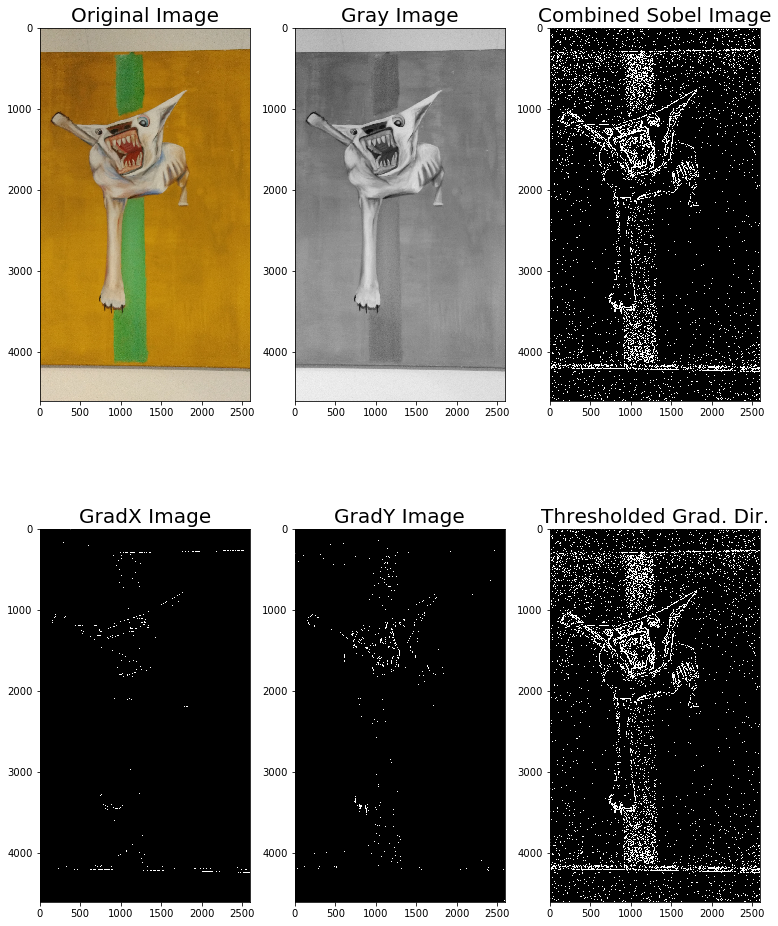

In [6]:
# Plot the result
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 15))
f.tight_layout()
ax1.imshow(im)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(gray, cmap='gray')
ax2.set_title('Gray Image', fontsize=20)
ax3.imshow(rgb_combined, cmap='gray')
ax3.set_title('Combined Sobel Image', fontsize=20)
ax4.imshow(gradx, cmap='gray')
ax4.set_title('GradX Image', fontsize=20)
ax5.imshow(grady, cmap='gray')
ax5.set_title('GradY Image', fontsize=20)
ax6.imshow(((mag_binary == 1) & (dir_binary == 1)), cmap='gray')
ax6.set_title('Thresholded Grad. Dir.', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## 2. Prueba en Videos

In [7]:
def process_image(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = GaussianBlur(gray, kernel = 5)
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/4))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    
    rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.uint8)
    
    retval, threshold = cv2.threshold(rgb_combined, 0, 255, cv2.THRESH_BINARY)
    
    return threshold

In [ ]:
filter_output = 'Batman_Filter.mp4'
clip1 = VideoFileClip("Batman.mp4")
batman_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time batman_clip.write_videofile(filter_output, audio=False)

[MoviePy] >>>> Building video Batman_Filter.mp4
[MoviePy] Writing video Batman_Filter.mp4



  0%|          | 0/265 [00:00<?, ?it/s]

 17%|█▋        | 46/265 [21:32<1:45:42, 28.96s/it]

In [30]:
HTML("""
<video width="720" height="480" controls>
  <source src="{0}">
</video>
""".format(filter_output))

## 3. LIVE

In [ ]:
import cv2
import numpy
cap = cv2.VideoCapture(0)  # 0 for Python 3, 1 for Python 2. No idea why?!!

while True:
    ret, frame = cap.read()
    cv2.imshow('frame' ,frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

#while(cap.isOpened()):
 #   ret, frame = cap.read()
  #  if ret==True:
   #     frame = cv2.flip(frame,180)
    #    new_frame = process_image(frame)
     #   out.write(new_frame)
#
 #       cv2.imshow('frame',new_frame)
  #      if cv2.waitKey(1) & 0xFF == ord('q'):
   #         break
    #else:
     #   break


# Release everything if job is finished
cap.release()
#out.release()
cv2.destroyAllWindows()